In [3]:
import itertools
import random
import time
from datetime import datetime

import pandas as pd

from generateSyntheticData import * 
from Code.qualityMeasure import *

import matplotlib.pyplot as plt
import pickle

from Code.BeamSearch.BeamSearch import *
from Code.BUSPaS.BUSPaS import *
from Code.MCTS4DM.MCTS4DM import *

from Code.diversity import *

from syntheticExpHelperFunctions import *

In [4]:
#TODO configuration optimization synthetic data?
#TODO Hyper-parameter tuning Search Strategies?

In [5]:
use_experiment_parameters = True # experiment_parameters=False gives a trial set of parameters for quick testing #TODO Before run Select right experiment values

#BS
w = 20
comparison_type_bs = 'complement'
ensure_diversity = True
allow_exclusion_bs = False
min_coverage_abs_bs = 3
min_error = 0.01
correct_for_size = no_size_corr


#MCTS
allow_exclusion_ms = False
minutes = 'dependant on BUSPaS time'

ucb_type='SP-MCTS'
ucb_params={}
size_correction_method = no_size_corr
roll_out_strategy='direct-freq'
reward_policy = 'max_path'
reward_policy_k = 3
memory_policy = 'all'
memory_policy_k_value = 3
update_policy = 'max_update'
update_policy_k = 3


#BUS
number_of_row_pairs=50
z = 2
min_coverage_abs_bus=3
comparison_type_bus = "complement"
size_corr = no_size_corr

In [6]:
if use_experiment_parameters:
    nr_attrs = [16,32]
    true_subgroup_attributes_list = [2,3]
    n_s = [500,1000]
    nr_tps = [48]
    nr_iterations = 5
    
    dev_sgs = [0.1,0.5, 1] # deviation_in_true_subgroup
    outliers_percs = [0.01,0.05]
    
    delta_mu_s = [1,2] # delta_mu_in_true_subgroup
else:
    nr_attrs = [8]
    true_subgroup_attributes_list = [2]
    n_s = [30]
    nr_tps = [24]
    nr_iterations = 2
    
    dev_sgs = [0.1] # deviation_in_true_subgroup
    outliers_percs = [0.05]
    
    delta_mu_s = [3] # delta_mu_in_true_subgroup

# Search Strategy parameters
d = 3
q = 10
bins = 5
min_cov = 0.01


In [7]:
iterations = [i+1 for i in range(nr_iterations)]
combinations = itertools.product(nr_tps, outliers_percs, nr_attrs, true_subgroup_attributes_list, n_s, delta_mu_s, dev_sgs)
combinations = [list(combination) for combination in combinations]

combs =  len(combinations) * len(iterations) 

print('number of experiments= ', combs)

results_columns = ['exp_id', 'iter.', 'N', 'T', 'k', 'lits', 'o', 'delta_mu', 'dev_sg',
                        'bs_ts_found',
                        'bs_>_ts',
                        'bs_sts_found',
                        'bs_time',
                        'bs_time_q',
                        'bs_#q',
                        'bs_ts_cover',
                        'bs_max_qual',
                        'bs_red_0.5',
                        'bs_red_0.7',
                        'bs_div_0.5',
                        'bs_div_0.7',
                        'mc_ts_found',
                        'mc_>_ts',
                        'mc_sts_found',
                        'mc_time',
                        'mc_time_q',
                        'mc_#q',
                        'mc_ts_cover',
                        'mc_max_qual',
                        'mc_red_0.5',
                        'mc_red_0.7',
                        'mc_div_0.5',
                        'mc_div_0.7',                   
                        'bus_ts_found',
                        'bus_>_ts',
                        'bus_sts_found',
                        'bus_time',
                        'bus_time_q',
                        'bus_#q',
                        'bus_ts_cover',
                        'bus_max_qual',
                        'bus_red_0.5',
                        'bus_red_0.7',
                        'bus_div_0.5',
                        'bus_div_0.7']

if d < np.array(true_subgroup_attributes_list).max(): raise Exception("No subgroups will be found for too small d")

number of experiments=  480


In [106]:
len(pd.read_pickle('./pre_results/synthetic_data_experiment_202501071808_5 - Copy.pkl').values.tolist())


465

In [8]:
fresh_start = True #TODO Check before running experiment

if fresh_start == False:
    start_point = 465
    
    combs_count = start_point
    results = pd.read_pickle('./pre_results/synthetic_data_experiment_202501071808_5 - Copy.pkl').values.tolist()
    prog = start_point
    
    experiment_start_time_code = '202501071808'
    experiment_start_time = '20250107180807'
    experiment_name = f'synthetic_data_experiment_{experiment_start_time_code}'
    
    combinations = combinations[int(start_point/nr_iterations):]
else:
    combs_count = 0
    results = []
    prog = 0
    experiment_start_time_code = datetime.now().strftime("%Y%m%d%H%M")
    experiment_start_time = datetime.now().strftime("%Y%m%d%H%M%S")
    experiment_name = f'synthetic_data_experiment_{experiment_start_time_code}'


# Iterate over the combinations
for combination in combinations:
    nr_tp, outliers_perc, nr_attr, true_subgroup_attributes, n, delta_mu, dev_sg = combination
    for iteration in iterations:
        combs_count += 1
        print('Experiment ', combs_count,'/',combs,' : Config : ', nr_tp, outliers_perc, nr_attr, true_subgroup_attributes, n, delta_mu, dev_sg)
        print('at ',datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        
        ######### ----- ----- ##########
        # we generate a dataset with a true subgroup
        
        df, features, description_true_subgroup = generator_synthetic_data_with_true_subgroup(n=n,
                                                   nr_attr=         nr_attr,
                                                   delta_mu_in_true_subgroup=        delta_mu,
                                                   nr_tp=           nr_tp,
                                                   true_subgroup_attributes=true_subgroup_attributes,
                                                   deviation_in_true_subgroup=          dev_sg,
                                                   outliers_perc=   outliers_perc,
                                                   ts_type=         'rw',
                                                   true_sg_type=    "error_shift")
        
        ######### ----- ----- ##########
        # we then prepare the experiment and make a distance matrix
        
        time_start_distance_matrix = time_start_experiment = time.time()
        
        distance_matrix = calculate_distance_matrix(df,euclidean_distance_slopes)
        
        time_end_distance_matrix = time.time()
        duration_distance_matrix = time_end_distance_matrix - time_start_distance_matrix
    

        ######### ----- ----- ##########
        # Beam Search
        print('Experiment ', combs_count,'/',combs,' : Beam Search')
        beam_search = BeamSearch(df)
        bs = beam_search.EMM( features,
            w=w,
            d=d,
            q=q,
            quality_measure=cluster_based_quality_measure,
            catch_all_description=[],
            comparison_type=comparison_type_bs,
            target='target',
            n_chunks=bins,
            ensure_diversity=ensure_diversity,
            report_progress= False,
            allow_exclusion=allow_exclusion_bs,
            min_coverage = min_cov,
            min_coverage_abs = min_coverage_abs_bs,
            min_error = min_error,
            distance_matrix=distance_matrix,
            correct_for_size=correct_for_size,
            show_result=False)
        
        
        ######### ----- ----- ##########
        # BUSPaS
        print('Experiment ', combs_count,'/',combs,' : BUSPaS')
        bottom_up = BUSPaS(df,
            distance_matrix,
            number_of_row_pairs=number_of_row_pairs,
            depth=d,
            q=q,
            nr_chunks=bins,
            min_coverage_perc=min_cov,
            min_coverage_abs=min_coverage_abs_bus)
        # bottom_up.num_to_cat_attribute_converter() #not needed for this 
        bottom_up.find_quality(quality_measure = cluster_based_quality_measure, comparison_type = comparison_type_bus , size_corr = size_corr)
        
        
        ######### ----- ----- ##########
        # MCTS4DM
        print('Experiment ', combs_count,'/',combs,' : MCTS4DM')
        monte_carlo = MCTS4DM(df, 'target',
            q = q,
            root_description = [],
            n_chunks = bins,
            allow_exclusion = allow_exclusion_ms,
            minutes = bottom_up.duration/60, # was: "round(bottom_up.duration,0)/60" in first version
            max_nr_iterations = float('inf'),
            ucb_type=ucb_type, #or UCB1, UCB1-Tuned, SP-MCTS, UCT, DFS-UCT
            ucb_params=ucb_params,
            quality_params={},
            matrix = distance_matrix,
            size_correction_method = size_correction_method,
            max_desc_length = d,
            min_coverage = min_cov,
            roll_out_strategy=roll_out_strategy, #or large-freq or naive
            reward_policy = reward_policy, #or random_pick, mean_path, mean_top_k
            reward_policy_k = reward_policy_k,
            memory_policy = memory_policy, #or top_k
            memory_policy_k_value = memory_policy_k_value,
            update_policy = update_policy, #or mean_update, top_k_mean_update
            update_policy_k = update_policy_k,
            show_progress = False,
            show_result=False)
        monte_carlo.run()
        
        
        ######### ----- ----- ##########
        # retrieve performance of search strategies compared to true subgroup. 
        # positive: beam_search_found_true_subgroup=True
        # positive: beam_search_found_true_subgroup=False and beam_search_all_qualities_better_than_true_subgroup=True
        # negative: beam_search_found_true_subgroup=False and beam_search_all_qualities_better_than_true_subgroup=False
        print('Experiment ', combs_count,'/',combs,' : Metrics')
        beam_search_found_true_subgroup, beam_search_rank_true_subgroup = true_subgroup_description_analysis(description_true_subgroup, beam_search.descriptions)
        beam_search_true_subgroup_quality_rank, beam_search_all_qualities_better_than_true_subgroup = true_subgroup_quality_analysis(description_true_subgroup, beam_search.result, df, distance_matrix)
        beam_search_found_subset_true_subgroup = not(true_subgroup_description_analysis_for_small_d(description_true_subgroup, beam_search.descriptions,d) is None)
        beam_search_ground_truth_cover_similarity = ground_truth_quality(df,[description_true_subgroup],beam_search.descriptions)
        redundancy_bs_point5, result_local_optima_bs_point5, _, _ = redundancy(beam_search.result, df, similarity_threshold=0.5, result_order_qdc=(0, 3, 1))
        diversity_bs_point5 = diversity(result_local_optima_bs_point5, result_is_local_optima=True)
        redundancy_bs_point7, result_local_optima_bs_point7, _, _ = redundancy(beam_search.result, df, similarity_threshold=0.7, result_order_qdc=(0, 3, 1))
        diversity_bs_point7 = diversity(result_local_optima_bs_point7, result_is_local_optima=True) 

        
        monte_carlo_found_true_subgroup, monte_carlo_rank_true_subgroup = true_subgroup_description_analysis(description_true_subgroup, monte_carlo.descriptions)
        monte_carlo_true_subgroup_quality_rank, monte_carlo_all_qualities_better_than_true_subgroup = true_subgroup_quality_analysis(description_true_subgroup, 
                                                                                                             monte_carlo.result, df, distance_matrix)
        monte_carlo_found_subset_true_subgroup = not(true_subgroup_description_analysis_for_small_d(description_true_subgroup, monte_carlo.descriptions,d) is None)
        monte_carlo_ground_truth_cover_similarity = ground_truth_quality(df,[description_true_subgroup],monte_carlo.descriptions)
        redundancy_mcts_point5, result_local_optima_mcts_point5, _, _ = redundancy(monte_carlo.result, df, similarity_threshold=0.5, result_order_qdc=(0, 3, 1))
        diversity_mcts_point5 = diversity(result_local_optima_mcts_point5, result_is_local_optima=True) 
        redundancy_mcts_point7, result_local_optima_mcts_point7, _, _ = redundancy(monte_carlo.result, df, similarity_threshold=0.7, result_order_qdc=(0, 3, 1))
        diversity_mcts_point7 = diversity(result_local_optima_mcts_point7, result_is_local_optima=True)         
        
        bottom_up_found_true_subgroup, bottom_up_rank_true_subgroup = true_subgroup_description_analysis(description_true_subgroup, bottom_up.descriptions)
        bottom_up_true_subgroup_quality_rank, bottom_up_all_qualities_better_than_true_subgroup = true_subgroup_quality_analysis(description_true_subgroup, 
                                                                                                             bottom_up.result, df, distance_matrix)
        bottom_up_found_subset_true_subgroup = not(true_subgroup_description_analysis_for_small_d(description_true_subgroup,bottom_up.descriptions,d) is None)
        bottom_up_ground_truth_cover_similarity = ground_truth_quality(df,[description_true_subgroup],bottom_up.descriptions)
        redundancy_bus_point5, result_local_optima_bus_point5, _, _ = redundancy(bottom_up.result, df, similarity_threshold=0.5, result_order_qdc=(0, 2, 1))
        diversity_bus_point5 = diversity(result_local_optima_bus_point5, result_is_local_optima=True) 
        redundancy_bus_point7, result_local_optima_bus_point7, _, _ = redundancy(bottom_up.result, df, similarity_threshold=0.7, result_order_qdc=(0, 2, 1))
        diversity_bus_point7 = diversity(result_local_optima_bus_point7, result_is_local_optima=True) 
        
        ######### ----- ----- ##########
        # documentation and save results
        
        exp_id = hash(str(n)+str(nr_tp)+str(nr_attr)+str(true_subgroup_attributes)+str(outliers_perc)+str(delta_mu)+str(dev_sg))

        results.append([exp_id, iteration, n, nr_tp, nr_attr, true_subgroup_attributes, outliers_perc, delta_mu, dev_sg,
                        beam_search_found_true_subgroup,
                        beam_search_all_qualities_better_than_true_subgroup,
                        beam_search_found_subset_true_subgroup,
                        beam_search.duration,
                        beam_search.duration_quality,
                        beam_search.count_quality,
                        beam_search_ground_truth_cover_similarity,
                        beam_search.max_quality,
                        redundancy_bs_point5,
                        redundancy_bs_point7,
                        diversity_bs_point5,
                        diversity_bs_point7,
                        monte_carlo_found_true_subgroup,
                        monte_carlo_all_qualities_better_than_true_subgroup,
                        monte_carlo_found_subset_true_subgroup,
                        monte_carlo.duration,
                        monte_carlo.duration_quality,
                        monte_carlo.count_quality,
                        monte_carlo_ground_truth_cover_similarity,
                        monte_carlo.max_quality,
                        redundancy_mcts_point5,
                        redundancy_mcts_point7,
                        diversity_mcts_point5,
                        diversity_mcts_point7,                        
                        bottom_up_found_true_subgroup,
                        bottom_up_all_qualities_better_than_true_subgroup,
                        bottom_up_found_subset_true_subgroup,
                        bottom_up.duration,
                        bottom_up.duration_quality,
                        bottom_up.count_quality,
                        bottom_up_ground_truth_cover_similarity,
                        bottom_up.max_quality,
                        redundancy_bus_point5,
                        redundancy_bus_point7,
                        diversity_bus_point5,
                        diversity_bus_point7])

        pickle_title = './pre_results/{}_{}.pkl'.format(experiment_name,iteration)
        df_results = pd.DataFrame(results,columns=results_columns)
        df_results.to_pickle(pickle_title)
        
        ######### ----- ----- ##########
        # progress notification
        
        prog+=1
        print(" ")
        print(time.strftime('%Y-%m-%d %H:%M:%S'),' progress: ',round(prog/combs,3),' thus finished ',prog,'/',combs)
        print(" ")

experiment_end_time = datetime.now().strftime("%Y%m%d%H%M%S")
df_results.to_pickle('./results/{}.pkl'.format(experiment_name))
df_results

Experiment  1 / 480  : Config :  48 0.01 16 2 500 1 0.1
at  2025-01-20 21:31:37
Experiment  1 / 480  : Beam Search
Experiment  1 / 480  : BUSPaS
Experiment  1 / 480  : MCTS4DM
Experiment  1 / 480  : Metrics
 
2025-01-20 21:31:53  progress:  0.002  thus finished  1 / 480
 
Experiment  2 / 480  : Config :  48 0.01 16 2 500 1 0.1
at  2025-01-20 21:31:53
Experiment  2 / 480  : Beam Search
Experiment  2 / 480  : BUSPaS
Experiment  2 / 480  : MCTS4DM
Experiment  2 / 480  : Metrics
 
2025-01-20 21:32:07  progress:  0.004  thus finished  2 / 480
 
Experiment  3 / 480  : Config :  48 0.01 16 2 500 1 0.1
at  2025-01-20 21:32:07
Experiment  3 / 480  : Beam Search
Experiment  3 / 480  : BUSPaS
Experiment  3 / 480  : MCTS4DM
Experiment  3 / 480  : Metrics
 
2025-01-20 21:32:21  progress:  0.006  thus finished  3 / 480
 
Experiment  4 / 480  : Config :  48 0.01 16 2 500 1 0.1
at  2025-01-20 21:32:21
Experiment  4 / 480  : Beam Search
Experiment  4 / 480  : BUSPaS
Experiment  4 / 480  : MCTS4DM
Exper

,exp_id,iter.,N,T,k,lits,o,delta_mu,dev_sg,bs_ts_found,...,bus_sts_found,bus_time,bus_time_q,bus_#q,bus_ts_cover,bus_max_qual,bus_red_0.5,bus_red_0.7,bus_div_0.5,bus_div_0.7
0,-6594374310800186225,1,500,48,16,2,0.01,1,0.1,True,...,True,2.629758,0.604798,908,1.000000,9.939,0.1,0.0,83.764488,93.612762
1,-6594374310800186225,2,500,48,16,2,0.01,1,0.1,False,...,True,2.334857,0.545188,863,1.000000,10.233,0.1,0.0,82.517250,91.983337
2,-6594374310800186225,3,500,48,16,2,0.01,1,0.1,True,...,True,2.146182,0.486014,746,1.000000,8.954,0.1,0.0,77.505058,86.305107
3,-6594374310800186225,4,500,48,16,2,0.01,1,0.1,True,...,True,3.022439,0.720732,1116,0.622951,10.491,0.0,0.0,102.402946,102.402946
4,-6594374310800186225,5,500,48,16,2,0.01,1,0.1,True,...,True,5.528153,1.275491,1126,1.000000,8.497,0.1,0.0,75.882706,84.305664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-2852595880789445913,1,1000,48,32,3,0.05,2,1.0,False,...,True,41.344479,16.311179,7808,1.000000,2.064,0.0,0.0,11.960032,11.960032
476,-2852595880789445913,2,1000,48,32,3,0.05,2,1.0,True,...,True,39.854116,15.831714,7800,1.000000,2.020,0.0,0.0,12.100229,12.100229
477,-2852595880789445913,3,1000,48,32,3,0.05,2,1.0,False,...,True,42.943836,16.950223,8337,1.000000,2.090,0.0,0.0,11.817291,11.817291
478,-2852595880789445913,4,1000,48,32,3,0.05,2,1.0,False,...,True,54.835204,21.813330,10805,1.000000,2.075,0.0,0.0,11.928946,11.928946


In [9]:
conf_bs = {
    'w':w,
    'comparison_type_bs':comparison_type_bs,
    'ensure_diversity':ensure_diversity,
    'allow_exclusion_bs':allow_exclusion_bs,
    'min_coverage_abs_bs' : min_coverage_abs_bs,
    'min_error' : min_error,
    'correct_for_size':correct_for_size,
} 

conf_mc = {
    'allow_exclusion_ms' : allow_exclusion_ms,
    'minutes' : minutes,
    'ucb_type':ucb_type,
    'ucb_params':ucb_params,
    'size_correction_method' : size_correction_method,
    'roll_out_strategy':roll_out_strategy,
    'reward_policy' : reward_policy,
    'reward_policy_k' : reward_policy_k,
    'memory_policy' : memory_policy,
    'memory_policy_k_value' : memory_policy_k_value,
    'update_policy' : update_policy,
    'update_policy_k' : update_policy_k
} 

conf_bus = {
    'number_of_row_pairs':number_of_row_pairs,
    'z':z,
    'min_coverage_abs_bus':min_coverage_abs_bus,
    'comparison_type_bus' : comparison_type_bus,
    'size_corr' : size_corr
} 


meta_data_exp = {'experiment_start_time': experiment_start_time,
'experiment_end_time': experiment_end_time,
'nr_experiment':len(df_results),

#generate data
'nr_attrs': nr_attrs,
'true_subgroup_attributes_list': true_subgroup_attributes_list,
'n_s': n_s,
'nr_tps': nr_tps,
'nr_iterations': nr_iterations,

#generate data: true subgroup
'dev_sgs': dev_sgs,
'outliers_percs': outliers_percs,
'delta_mu_s': delta_mu_s,

# General Search Strategy parameters
'd': d,
'q': q,
'bins': bins,
'min_cov': min_cov,

# Beam Search - Search Strategy parameters
'conf_bs':conf_bs,
# MCTS4DM - Search Strategy parameters
'conf_mc':conf_mc,
# BUSPaS - Search Strategy parameters
'conf_bus':conf_bus
}

pickle.dump(meta_data_exp, open('./results/{}_meta.pkl'.format(experiment_name), 'wb'))

## Saved configurations experiment

file_path = 'results/synthetic_data_experiment_202410182307.pkl'

In [ ]:
nr_attrs = [8,16]
true_subgroup_attributes_list = [2,3,4]
n_s = [500,1000]
nr_tps = [48]
nr_iterations = 10

dev_sgs = [1,2] # deviation_in_true_subgroup
outliers_percs = [0,0.1]

delta_mu_s = [0,3] # delta_mu_in_true_subgroup


# Search Strategy parameters
d = 3
q = 10
bins = 5
min_cov = 0.01

### Check if synthetic data generate configuration makes sense

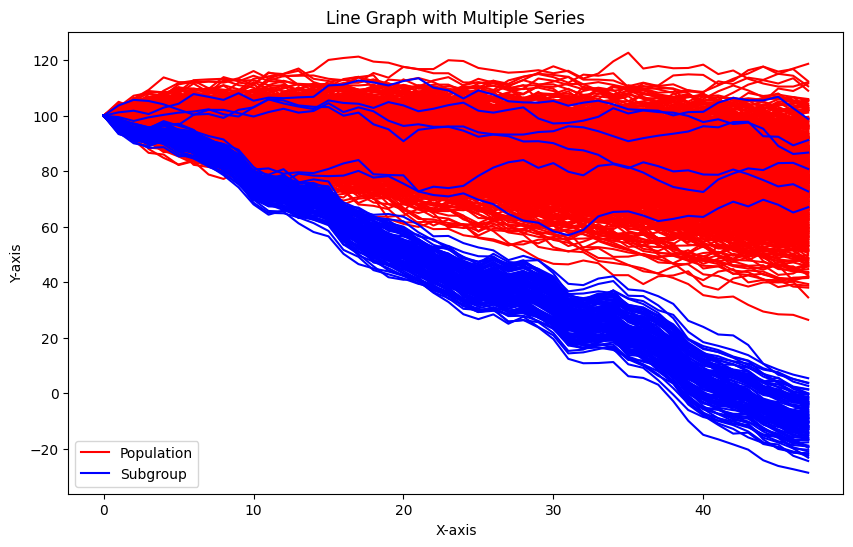

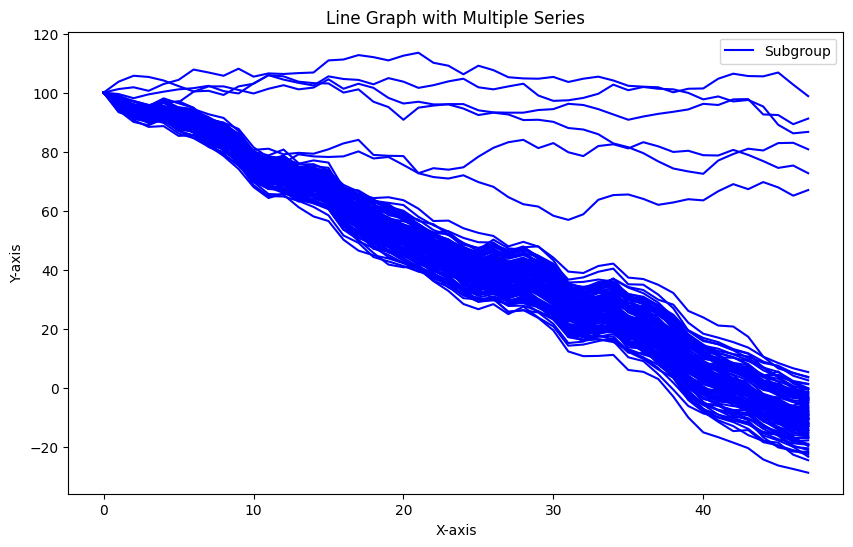

In [14]:
# (n=1000,
#                                                                                     nr_attr=         8,
#                                                                                     delta_mu_in_true_subgroup=3,
#                                                                                     nr_tp=           48,
#                                                                                     true_subgroup_attributes=3,
#                                                                                     deviation_in_true_subgroup=2,
#                                                                                     outliers_perc=   0.2,
#                                                                                     ts_type=         'rw', # rw cauchy_rw 
#                                                                                     true_sg_type=    "error_shift",
#                                                                                     typical_behavior_sig = 6, 
#                                                                                     typical_behavior_mu = -0.5)



df, features, description_true_subgroup = generator_synthetic_data_with_true_subgroup(n=1000,
                                                                                    nr_attr=         8,
                                                                                    delta_mu_in_true_subgroup=2,
                                                                                    nr_tp=           48,
                                                                                    true_subgroup_attributes=3,
                                                                                    deviation_in_true_subgroup=1,
                                                                                    outliers_perc=   0.05,
                                                                                    ts_type=         'rw', # rw cauchy_rw 
                                                                                    true_sg_type=    "error_shift",
                                                                                    typical_behavior_sig = 2, 
                                                                                    typical_behavior_mu = -0.5)
 
subgroup = df.query(as_string(description_true_subgroup))
subgroup_timeseries = subgroup['target']

complement = df.loc[~df.index.isin(subgroup.index)]
complement_timeseries = complement['target']


# Assuming series1 and series2 are pandas.Series, where each element is a list of values
def plot_multiple_series(series1: pd.Series, series2: pd.Series):
    plt.figure(figsize=(10, 6))

    if all:
        # Plotting the second series (multiple lists) in red
        for line in series2:
            plt.plot(line, color='red', label='Population')

    # Plotting the first series (multiple lists) in blue
    for line in series1:
        plt.plot(line, color='blue', label='Subgroup')


    plt.title('Line Graph with Multiple Series')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Ensure labels are only displayed once for each series
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.show()
    
all = True
# Call the function to plot the series
plot_multiple_series(subgroup_timeseries, complement_timeseries)
all = False
# Call the function to plot the series
plot_multiple_series(subgroup_timeseries, complement_timeseries)

In [34]:
ground_truth_quality(df, [description_true_subgroup], [["A1numbOfVal2 == '1'"]])

0.6666666666666666

## Archive

In [30]:
ts = [["A1numbOfVal2 == '1'", "A3numbOfVal2 == '1'", "A2numbOfVal2 == '1'"],
["A4numbOfVal2 == '1'", "A2numbOfVal2 == '1'", "A3numbOfVal2 == '1'"],
["A1numbOfVal2 == '1'", "A3numbOfVal2 == '1'", "A5numbOfVal2 == '2'"],
["A4numbOfVal2 == '1'", "A3numbOfVal2 == '1'", "A5numbOfVal2 == '2'"],
["A3numbOfVal2 == '1'", "A2numbOfVal2 == '2'", "A1numbOfVal2 == '2'"],
["A5numbOfVal2 == '2'", "A3numbOfVal2 == '1'"],
["A2numbOfVal2 == '2'", "A1numbOfVal2 == '2'", "A5numbOfVal2 == '2'"],
["A3numbOfVal2 == '1'", "A1numbOfVal2 == '2'", "A4numbOfVal2 == '1'"],
["A3numbOfVal2 == '1'", "A2numbOfVal2 == '2'", "A5numbOfVal2 == '2'"],
["A5numbOfVal2 == '2'", "A1numbOfVal2 == '2'"]]
z = true_subgroup_description_analysis_for_small_d(["A1numbOfVal2 == '1'", "A3numbOfVal2 == '1'", "A5numbOfVal2 == '2'"],ts,3)

In [33]:
a = not(z is None)

In [34]:
a

True

In [7]:
df, features, description_true_subgroup = generator_synthetic_data_with_true_subgroup(n=500,
                                                   nr_attr=         5,
                                                   delta_mu=        2,
                                                   nr_tp=           24,
                                                   true_subgroup_attributes=3,
                                                   dev_sg=          0.1,
                                                   outliers_perc=   0.1,
                                                   ts_type=         'cauchy_rw',
                                                   true_sg_type=    "error_shift")
mat = calculate_distance_matrix(df,euclidean_distance_slopes)



--- 0.36266231536865234 seconds ---


In [18]:
bus = BUSPaS(df,
     mat,
     number_of_row_pairs=250,
     depth=3,
     q=10,
     nr_chunks=5,
     min_coverage_perc=0.01,
     min_coverage_abs=0)

# bus.num_to_cat_attribute_converter() #not needed for this 

bus.findQuality(quality_measure = cluster_based_quality_measure, comparison_type = "complement" , size_corr = no_size_corr)
bus.result

0.5531493944041304
8.814457139359538
53.57703345752817
0.5075035623982515
4.961996429857701
108.92135000561218
0.5080720247475105
24.424043049033756
5.329073319764403
39.022570220106054
0.5098297426577754
23.550211416075076
0.514430350337005
18.440040098280225
9.001694980042641
10.619959444068906
54.00907133733081
27.756994851968187
22.389252706965763
27.908423603368107
0.5180240148448602
30.749164910776532
2.2934805145211294
17.367052027586656
9.28851807349215
64.87582232030434
2.696672547362732
29.6983012846544
1.5785554645021929
20.72034168186473
4.556240752954896
0.5199450982981347
18.02720960507194
11.447920026377256
17.376134430319865
5.186743053107209
37.90106320868065
24.038913810677528
31.77460889373138
5.109071908349157
12.038526113555776
18.945409052981802
16.39164496746617
10.210248327536103
13.362811469146896
19.526405219903136
25.482428320427097
17.901343230015424
7.005136576466659
18.838283264962786
24.32772586222337


[(np.float64(108.92135000561218),
  0.132,
  ["A1numbOfVal2 == '1'", "A3numbOfVal2 == '1'", "A2numbOfVal2 == '1'"]),
 (np.float64(64.87582232030434),
  0.11,
  ["A1numbOfVal2 == '1'", "A4numbOfVal2 == '2'", "A2numbOfVal2 == '1'"]),
 (np.float64(54.00907133733081),
  0.136,
  ["A1numbOfVal2 == '1'", "A5numbOfVal2 == '1'", "A2numbOfVal2 == '1'"]),
 (np.float64(53.57703345752817),
  0.24,
  ["A1numbOfVal2 == '1'", "A2numbOfVal2 == '1'"]),
 (np.float64(39.022570220106054),
  0.104,
  ["A5numbOfVal2 == '2'", "A1numbOfVal2 == '1'", "A2numbOfVal2 == '1'"]),
 (np.float64(37.90106320868065),
  0.13,
  ["A1numbOfVal2 == '1'", "A4numbOfVal2 == '1'", "A2numbOfVal2 == '1'"]),
 (np.float64(31.77460889373138), 0.512, ["A2numbOfVal2 == '1'"]),
 (np.float64(30.749164910776532),
  0.262,
  ["A1numbOfVal2 == '1'", "A4numbOfVal2 == '1'"]),
 (np.float64(29.6983012846544),
  0.13,
  ["A5numbOfVal2 == '2'", "A1numbOfVal2 == '1'", "A4numbOfVal2 == '1'"]),
 (np.float64(27.908423603368107),
  0.248,
  ["A5numbO

In [4]:
MCTS4DM_instance = MCTS4DM(df, 'target',
            q = 10,
            root_description = [],
            n_chunks = 5,
            allow_exclusion = False,
            minutes = 0.2,
            max_nr_iterations = float('inf'),
            ucb_type='SP-MCTS', #or UCB1, UCB1-Tuned, SP-MCTS, UCT, DFS-UCT
            ucb_params={},
            quality_params={},
            matrix = mat,
            size_correction_method = no_size_corr,
            max_desc_length=3,
            min_coverage=0.01,
            roll_out_strategy='direct-freq', #or large-freq or naive
            reward_policy = 'max_path', #or random_pick, mean_path, mean_top_k
            reward_policy_k = 3,
            memory_policy = 'all', #or top_k
            memory_policy_k_value = 3,
            update_policy = 'max_update', #or mean_update, top_k_mean_update
            update_policy_k = 3,
            show_progress = True)

MCTS4DM_instance.run()
MCTS4DM_instance.result

started at  Thu Oct 17 11:14:10 2024
0.7274443737934658
0.6605551718719543
0.595290803718228
finished iteration:  1
Time left: 0h 0m 11s
1.2486946486530512
1.4282747357264016
1.2238272571955213
finished iteration:  2
Time left: 0h 0m 11s
0.8013176500297454
0.6949567121029713
2.5667060926751386
finished iteration:  3
Time left: 0h 0m 11s
1.3273863576584075
1.4047873125912984
1.2944274593714162
finished iteration:  4
Time left: 0h 0m 11s
1.8585078124950754
1.4570535181631874
2.033678204551785
finished iteration:  5
Time left: 0h 0m 11s
0.6891084938050649
0.6464740843561672
0.9356666947222003
finished iteration:  6
Time left: 0h 0m 11s
0.7524409671647097
0.6860208838837046
1.2131287584617048
finished iteration:  7
Time left: 0h 0m 11s
0.8336060983093271
0.6860208838837046
0.6032550326005108
finished iteration:  8
Time left: 0h 0m 11s
1.5078907344215846
1.1611258033718495
1.0820114405495274
finished iteration:  9
Time left: 0h 0m 11s
1.6254812738986726
1.3066304423422002
1.669781282914593


[(np.float64(9.856976710372955),
  0.112,
  142,
  ["A3numbOfVal2 == '1'", "A2numbOfVal2 == '1'", "A1numbOfVal2 == '1'"]),
 (np.float64(9.856976710372955),
  0.112,
  88,
  ["A1numbOfVal2 == '1'", "A2numbOfVal2 == '1'", "A3numbOfVal2 == '1'"]),
 (np.float64(3.0265834218220395),
  0.132,
  122,
  ["A4numbOfVal2 == '1'", "A3numbOfVal2 == '1'", "A2numbOfVal2 == '1'"]),
 (np.float64(2.7252558837655307),
  0.098,
  52,
  ["A5numbOfVal2 == '2'", "A1numbOfVal2 == '1'", "A3numbOfVal2 == '1'"]),
 (np.float64(2.5667060926751386),
  0.128,
  8,
  ["A5numbOfVal2 == '2'", "A4numbOfVal2 == '1'", "A3numbOfVal2 == '1'"]),
 (np.float64(2.489836198386734),
  0.23,
  145,
  ["A3numbOfVal2 == '1'", "A5numbOfVal2 == '2'"]),
 (np.float64(2.442848208205787),
  0.112,
  146,
  ["A3numbOfVal2 == '1'", "A5numbOfVal2 == '2'", "A2numbOfVal2 == '2'"]),
 (np.float64(2.347013287854425),
  0.254,
  75,
  ["A1numbOfVal2 == '2'", "A5numbOfVal2 == '2'"]),
 (np.float64(2.347013287854425),
  0.254,
  59,
  ["A5numbOfVal2 

In [91]:
MCTS4DM_instance.show_results()

 
 
--------------------------------- Results ---------------------------------
# 1 	 q=  4.7438  cov=  0.148
	 desc=  ["A3numbOfVal2 == '1'", "A2numbOfVal2 == '1'" ,
			 "A1numbOfVal2 == '1'"]
# 2 	 q=  4.7438  cov=  0.148
	 desc=  ["A1numbOfVal2 == '1'", "A2numbOfVal2 == '1'" ,
			 "A3numbOfVal2 == '1'"]
# 3 	 q=  3.7333  cov=  0.108
	 desc=  ["A1numbOfVal2 == '1'", "A2numbOfVal2 == '2'" ,
			 "A5numbOfVal2 == '1'"]
# 4 	 q=  3.5408  cov=  0.12
	 desc=  ["A5numbOfVal2 == '1'", "A4numbOfVal2 == '1'" ,
			 "A3numbOfVal2 == '2'"]
# 5 	 q=  3.5408  cov=  0.12
	 desc=  ["A4numbOfVal2 == '1'", "A5numbOfVal2 == '1'" ,
			 "A3numbOfVal2 == '2'"]
# 6 	 q=  3.474  cov=  0.288
	 desc=  ["A1numbOfVal2 == '1'", "A3numbOfVal2 == '1'"]
 
# 7 	 q=  3.474  cov=  0.288
	 desc=  ["A3numbOfVal2 == '1'", "A1numbOfVal2 == '1'"]
 
# 8 	 q=  3.2709  cov=  0.148
	 desc=  ["A5numbOfVal2 == '2'", "A3numbOfVal2 == '1'" ,
			 "A1numbOfVal2 == '1'"]
# 9 	 q=  3.157  cov=  0.238
	 desc=  ["A2numbOfVal2 == '2'", "A

In [80]:
eval_quality( df.query(as_string(["A4numbOfVal2 == '1'", "A3numbOfVal2 == '1'"])),df,'target',cluster_based_quality_measure,'complement',distance_matrix=mat,correct_for_size=no_size_corr)


(np.float64(356.7080825775204), 0.1)

In [5]:
bs = BeamSearch(df) 
bs.EMM( features,
     w=30,
     d=3,
     q=10,
     quality_measure=cluster_based_quality_measure,
     catch_all_description=[],
     comparison_type='complement',
     target='target',
     n_chunks=5,
     ensure_diversity=True,
     report_progress= True,
     allow_exclusion=False,
     min_coverage = 0.01,
     min_coverage_abs = 3,
     min_error = 0.001,
     distance_matrix=mat,
     correct_for_size=no_size_corr)
bs.result

level :  0
    seed :  []
eta  []
eta  []
0 / 3 queue= 1 / 1 descr= 1 / 10
0.6891084938050649
0 / 3 queue= 1 / 1 descr= 2 / 10
1.8585078124950754
0 / 3 queue= 1 / 1 descr= 3 / 10
0.7524409671647097
0 / 3 queue= 1 / 1 descr= 4 / 10
1.5078907344215846
0 / 3 queue= 1 / 1 descr= 5 / 10
0.7274443737934658
0 / 3 queue= 1 / 1 descr= 6 / 10
1.6254812738986726
0 / 3 queue= 1 / 1 descr= 7 / 10
1.2486946486530512
0 / 3 queue= 1 / 1 descr= 8 / 10
0.8336060983093271
0 / 3 queue= 1 / 1 descr= 9 / 10
0.8013176500297454
0 / 3 queue= 1 / 1 descr= 10 / 10
1.3273863576584075
level :  1
    seed :  ["A1numbOfVal2 == '1'"]
0.6891084938050649
eta  ["A1numbOfVal2 == '1'"]
eta  ["A1numbOfVal2 == '1'"]
1 / 3 queue= 1 / 10 descr= 1 / 8
0.6433041254309716
1 / 3 queue= 1 / 10 descr= 2 / 8
1.2902070956369684
1 / 3 queue= 1 / 10 descr= 3 / 8
0.6464740843561672
1 / 3 queue= 1 / 10 descr= 4 / 8
1.2874890943292157
1 / 3 queue= 1 / 10 descr= 5 / 8
1.0226003458925879
1 / 3 queue= 1 / 10 descr= 6 / 8
0.6824972739268039
1

[(np.float64(9.856976710372955),
  0.112,
  88,
  ["A1numbOfVal2 == '1'", "A3numbOfVal2 == '1'", "A2numbOfVal2 == '1'"],
  {}),
 (np.float64(3.0265834218220395),
  0.132,
  207,
  ["A4numbOfVal2 == '1'", "A2numbOfVal2 == '1'", "A3numbOfVal2 == '1'"],
  {}),
 (np.float64(2.7252558837655307),
  0.098,
  92,
  ["A1numbOfVal2 == '1'", "A3numbOfVal2 == '1'", "A5numbOfVal2 == '2'"],
  {}),
 (np.float64(2.5667060926751386),
  0.128,
  226,
  ["A4numbOfVal2 == '1'", "A3numbOfVal2 == '1'", "A5numbOfVal2 == '2'"],
  {}),
 (np.float64(2.493238350102749),
  0.134,
  82,
  ["A3numbOfVal2 == '1'", "A2numbOfVal2 == '2'", "A1numbOfVal2 == '2'"],
  {}),
 (np.float64(2.489836198386734),
  0.23,
  39,
  ["A5numbOfVal2 == '2'", "A3numbOfVal2 == '1'"],
  {}),
 (np.float64(2.48414051009325),
  0.114,
  214,
  ["A2numbOfVal2 == '2'", "A1numbOfVal2 == '2'", "A5numbOfVal2 == '2'"],
  {}),
 (np.float64(2.4549460637189293),
  0.128,
  201,
  ["A3numbOfVal2 == '1'", "A1numbOfVal2 == '2'", "A4numbOfVal2 == '1'"],
